# Gesture Classification

This notebook is used to train classification models from csv dataset. 

> shift and rotation 

<a href="#evaluation">Go to Evaluation Cell</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
# set up
dataset = 'datasets/HandLandmarks1000.csv'

model_save_path = 'models/gesture_classifier.hdf5'
tflite_save_path = 'models/gesture_classifier.tflite'

LABELS = ['call', 'dislike', 'fist', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'rock', 'stop', 'stop_inverted'] 
NUM_CLASSES = len(LABELS)

## Dataset Preparation

In [3]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

In [4]:
X_dataset

array([[ 1.        ,  0.7100702 ,  0.5840761 , ...,  0.6014862 ,
         0.5510756 , -0.02362032],
       [ 1.        ,  0.588869  ,  0.6737625 , ...,  0.5168103 ,
         0.6284635 , -0.01756548],
       [ 0.        ,  0.2995245 ,  0.5965276 , ...,  0.50682276,
         0.61600465, -0.03615945],
       ...,
       [ 0.        ,  0.26178235,  0.51515234, ...,  0.30807483,
         0.40605247, -0.02462914],
       [ 1.        ,  0.6025023 ,  0.45756525, ...,  0.4871351 ,
         0.23205534,  0.1230498 ],
       [ 1.        ,  0.8320666 ,  0.4440706 , ...,  0.7311647 ,
         0.21871707, -0.05081773]], dtype=float32)

In [5]:
# shifting
point0s = X_dataset[:, 1:4]
shift = np.hstack((np.zeros((X_dataset.shape[0], 1)), np.hstack([point0s] * 21)))
X_dataset_shifted = X_dataset - shift
X_dataset_shifted = X_dataset_shifted.astype('float32')
X_dataset_shifted

array([[ 1.        ,  0.        ,  0.        , ..., -0.10858399,
        -0.03300053, -0.02362013],
       [ 1.        ,  0.        ,  0.        , ..., -0.07205868,
        -0.04529899, -0.01756538],
       [ 0.        ,  0.        ,  0.        , ...,  0.20729828,
         0.01947707, -0.03615942],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.04629248,
        -0.10909986, -0.02462909],
       [ 1.        ,  0.        ,  0.        , ..., -0.11536717,
        -0.22550991,  0.12304984],
       [ 1.        ,  0.        ,  0.        , ..., -0.1009019 ,
        -0.22535354, -0.05081779]], dtype=float32)

In [6]:
# rotation
def rotate_around_point0(landmark_array):
    landmarks_xy = landmark_array[1:].reshape(-1,3)[:,:2]
    point5 = landmarks_xy[5]
    dx, dy = point5
    angle = np.arctan2(dy, dx) + np.pi / 2
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotation_landmarks_xy = landmarks_xy.dot(rotation_matrix)
    rotated_landmarks_array = np.append(landmark_array[0], np.hstack((rotation_landmarks_xy, landmark_array[1:].reshape(-1,3)[:,2:])).flatten())
    return rotated_landmarks_array

X_dataset_rotated = np.zeros_like(X_dataset_shifted)
for idx, row in enumerate(X_dataset_shifted):
    X_dataset_rotated[idx] = rotate_around_point0(row)

X_dataset_rotated

array([[ 1.        ,  0.        ,  0.        , ..., -0.09276759,
        -0.06537347, -0.02362013],
       [ 1.        ,  0.        ,  0.        , ..., -0.06434396,
        -0.05571631, -0.01756538],
       [ 0.        ,  0.        ,  0.        , ...,  0.14421225,
        -0.15018243, -0.03615942],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.07331148,
        -0.09311929, -0.02462909],
       [ 1.        ,  0.        ,  0.        , ..., -0.13255759,
        -0.21585363,  0.12304984],
       [ 1.        ,  0.        ,  0.        , ..., -0.15520759,
        -0.19203128, -0.05081779]], dtype=float32)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset_rotated, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [8]:
y_train

array([11, 10,  4, ...,  5,  0,  7])

In [9]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.46499854e-02, -3.03592104e-02, -3.53255053e-03, -1.74814723e-02,
       -6.42406419e-02, -6.31396752e-03, -1.19725494e-02, -9.13958922e-02,
       -9.34291910e-03, -6.73653604e-03, -1.13111168e-01, -1.21399956e-02,
       -1.30653466e-09, -8.36642683e-02, -5.60127804e-03,  8.33551027e-03,
       -1.24269284e-01, -1.21110268e-02,  1.37177566e-02, -1.47527412e-01,
       -1.62667353e-02,  1.76510606e-02, -1.65475324e-01, -1.86763536e-02,
        1.19873174e-02, -7.88757354e-02, -7.98934232e-03,  2.11700182e-02,
       -1.21389315e-01, -1.36752427e-02,  2.63222661e-02, -1.48210704e-01,
       -1.76365878e-02,  2.96483524e-02, -1.68908313e-01, -1.99946221e-02,
        2.32459120e-02, -6.96625784e-02, -1.09539153e-02,  3.15008461e-02,
       -1.10384054e-01, -1.59018431e-02,  3.60650048e-02, -1.35814428e-01,
       -1.91632640e-02,  3.84291932e-02, -1.55357569e-01, -2.08177920e-02,
        3.46085988e-02, -

In [10]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(9000,) (9000, 64) (3000,) (3000, 64)


## Model Building

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [13]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [14]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [15]:
es_callback

In [16]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




54/71 [=====================>........] - ETA: 0s - loss: 1.7143 - accuracy: 0.4579
Epoch 1: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 3s 8ms/step - loss: 1.5521 - accuracy: 0.5114 - val_loss: 2.4054 - val_accuracy: 0.0890
Epoch 2/1000
50/71 [====================>.........] - ETA: 0s - loss: 0.7738 - accuracy: 0.7722

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


67/71 [===========================>..] - ETA: 0s - loss: 0.7396 - accuracy: 0.7794
Epoch 2: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 5ms/step - loss: 0.7368 - accuracy: 0.7802 - val_loss: 2.2982 - val_accuracy: 0.1057
Epoch 3/1000
68/71 [===========================>..] - ETA: 0s - loss: 0.5280 - accuracy: 0.8358
Epoch 3: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.5266 - accuracy: 0.8368 - val_loss: 2.0310 - val_accuracy: 0.2490
Epoch 4/1000
68/71 [===========================>..] - ETA: 0s - loss: 0.4283 - accuracy: 0.8658
Epoch 4: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.4276 - accuracy: 0.8651 - val_loss: 1.6446 - val_accuracy: 0.5237
Epoch 5/1000
67/71 [===========================>..] - ETA: 0s - loss: 0.3595 - accuracy: 0.8872
Epoch 5: saving model to models\gesture_classifier.hdf5
71/71 [===========

In [17]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.1158 - accuracy: 0.9760


In [18]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [19]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 164ms/step
[9.0447393e-06 9.9907327e-01 6.7903347e-06 9.1091439e-04 2.0301969e-09
 8.3273548e-09 5.3429674e-11 4.7215082e-10 3.7022501e-15 1.9989396e-12
 1.4879914e-10 9.1912350e-15]
1


# Confusion matrix

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

<a id="evaluation"></a>

### Evaluation 

 1/94 [..............................] - ETA: 2s

94/94 [==============================] - 0s 1ms/step


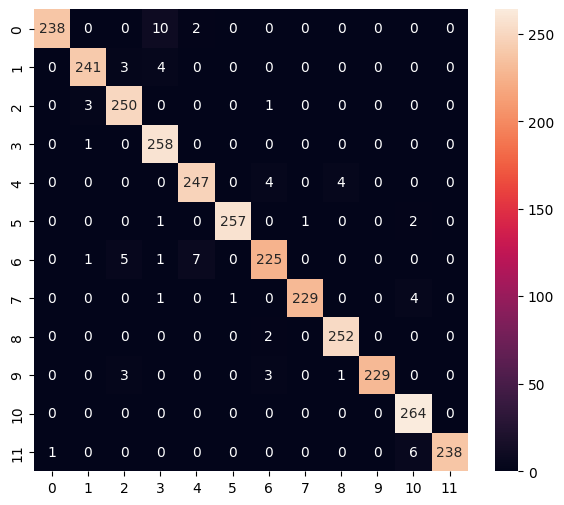

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       250
           1       0.98      0.97      0.98       248
           2       0.96      0.98      0.97       254
           3       0.94      1.00      0.97       259
           4       0.96      0.97      0.97       255
           5       1.00      0.98      0.99       261
           6       0.96      0.94      0.95       239
           7       1.00      0.97      0.98       235
           8       0.98      0.99      0.99       254
           9       1.00      0.97      0.98       236
          10       0.96      1.00      0.98       264
          11       1.00      0.97      0.99       245

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [21]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpntbfai6v\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpntbfai6v\assets


40376

### Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [25]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [26]:
np.array([X_test[0]])

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  4.14506793e-02, -5.43577522e-02,
        -1.46347992e-02,  6.59199432e-02, -1.15286469e-01,
        -1.70156863e-02,  8.57037231e-02, -1.61033705e-01,
        -1.96216945e-02,  9.99393240e-02, -1.92838594e-01,
        -1.70948412e-02, -3.36060513e-09, -1.45575985e-01,
         4.36391449e-03, -4.97373333e-03, -1.83848634e-01,
        -1.44664738e-02,  9.90142953e-03, -1.41694993e-01,
        -2.19034087e-02,  1.13274688e-02, -1.16920479e-01,
        -2.27735080e-02, -3.07963938e-02, -1.35485023e-01,
         3.57175292e-03, -3.68962623e-02, -1.68193385e-01,
        -1.68470759e-02, -1.48433419e-02, -1.16983324e-01,
        -2.19514538e-02, -1.19802346e-02, -1.02016151e-01,
        -2.11937707e-02, -5.97657189e-02, -1.17355824e-01,
        -1.26007677e-03, -6.51483387e-02, -1.50020376e-01,
        -2.25332472e-02, -4.14157175e-02, -1.04479782e-01,
        -1.26723582e-02, -3.72686833e-02, -9.01516229e-0

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.62370541e-06 9.98950303e-01 5.43716487e-06 1.03475188e-03
 1.89040161e-09 7.87852095e-09 4.97434940e-11 4.95633867e-10
 3.51018055e-15 1.74731280e-12 1.41130149e-10 1.02891294e-14]
1
CPU times: total: 0 ns
Wall time: 1 ms
